# Continuous Assessment 1


Using the Boston data set introduced during LAB work, apply linear regression modelling to predict the per capita crime rate using other variables in the data set. In other words, per capita crime rate is the response and the other variables are predictors.

## Additional Libraries and Tools

### [Github Repo](https://github.com/Ri-Dearg/data-analytics-dbs/)
This file and its commit history [can be found by clicking here](https://github.com/Ri-Dearg/data-analytics-dbs/blob/main/statistics/ca1-boston-data/ca1.ipynb).

### [Matplotlib ](https://matplotlib.org)
For creating plots and visualising data.

### [Numpy](https://numpy.org)
For scientific computing.

### [Pandas](https://pandas.pydata.org)
For data analysis and manipulation.

### [Seaborn](https://seaborn.pydata.org)
For data visualisation.

### [Statsmodels](https://www.statsmodels.org/stable/index.html)
For statistical exploration. 

### [Pylint](https://www.pylint.org)
Used as a linter for code quality control.

### [Ruff](https://docs.astral.sh/ruff/)
Used as both a linter and a formatter. Configuration has been adjusted to conform to PEP8 standard. 

### References
- Identifying and winsorising outliers:  
    - https://towardsdatascience.com/detecting-and-treating-outliers-in-python-part-3-dcb54abaf7b0/
    - https://careerfoundry.com/en/blog/data-analytics/how-to-find-outliers/



In [3]:
# Import necessary libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from statsmodels.formula.api import ols

# Reorder colour palette as the dark blue is harder to read.
def_palette = sns.color_palette('deep')
reordered_palette = [def_palette[i] for i in [9, 1, 2, 3, 4, 5, 6, 7, 8, 0]]
sns.set_palette(reordered_palette)


## Utilities
Functions used so as to not repeat code.


In [4]:
# Callable function to create plots
def multi_row_plot(
    seaborn_func: object,
    data: object,
    grid: tuple = (4, 4),
    size: tuple = (25, 20),
    *,
    y_col: bool = False,
) -> None:
    """Create a plot with default values.

    Args:
        seaborn_func (object): seaborn plot function to run.
        data (object): _description_
        grid (tuple, optional): Rows and columns. Defaults to (2, 7).
        size (tuple, optional): Width and Height. Defaults to (32, 7).
        y_col(None, optional): x axis if doing a correlation plot.

    """
    data_cols = data.columns

    # Structure plots to easily fit the data.
    fig_plot, axes = plt.subplots(grid[0], grid[1], figsize=(size[0], size[1]))
    # Flatten axes so it is easier to enumerate.
    axes = axes.flatten()
    # Cheks to see if it is a correlation plot.
    if y_col is True:
        for i, item in enumerate(data_cols[1:]):
            seaborn_func(data=data, x=item, y='CRIM', ax=axes[i])
    # Runs single predictor plot if not.
    else:
        for i, item in enumerate(data_cols):
            seaborn_func(data=data, x=item, ax=axes[i])

    # Hide any unused subplots.
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')


def winsorize_outliers(data_orig: object, data_win: object, col: str) -> None:
    """Find and clip outliers from the dataset.

    Args:
        data_orig (object): Original dataset.
        data_win (object): Copy of dataset.
        col (str): The name of the col to check.

    """
    # Find Quartile Ranges
    quart1 = data_orig[col].quantile(0.25)
    quart3 = data_orig[col].quantile(0.75)
    inter_quart = quart3 - quart1
    lower_bound = quart1 - 1.5 * inter_quart
    upper_bound = quart3 + 1.5 * inter_quart

    # Only clip the outliers
    data_win[col] = np.where(
        data_orig[col] < lower_bound,
        lower_bound,
        np.where(data_orig[col] > upper_bound, upper_bound, data_orig[col]),
    )


## Descriptive Analysis  
### a) Use descriptive statistics to explore the dataset.


In [5]:
# Access CSV file.
boston_csv = pd.read_csv('boston-data.csv')

First I will check the data types for the set and then check for missing or invalid values.

In [6]:
# Display and read data info and type.
boston_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   CRIM    506 non-null    float64
 1   ZN      506 non-null    float64
 2   INDUS   506 non-null    float64
 3   CHAS    506 non-null    int64  
 4   NOX     506 non-null    float64
 5   RM      506 non-null    float64
 6   AGE     506 non-null    float64
 7   DIS     506 non-null    float64
 8   RAD     506 non-null    int64  
 9   TAX     506 non-null    int64  
 10  PT      506 non-null    float64
 11  B       506 non-null    float64
 12  LSTAT   506 non-null    float64
 13  MV      506 non-null    float64
dtypes: float64(11), int64(3)
memory usage: 55.5 KB


In [7]:
# Sum any missing values.
boston_csv.isna().sum()

CRIM     0
ZN       0
INDUS    0
CHAS     0
NOX      0
RM       0
AGE      0
DIS      0
RAD      0
TAX      0
PT       0
B        0
LSTAT    0
MV       0
dtype: int64

Examine the general statistics of each item in the data set.

In [8]:
# Use describe to view summary statistics for each variable.
boston_csv.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PT,B,LSTAT,MV
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674030,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148862,2.105710,8.707259,168.537116,2.164946,91.294863,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377487,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440002,11.360000,21.200001
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.074999,5.188425,24.000000,666.000000,20.200001,396.225006,16.954999,25.000000
max,88.976196,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.899994,37.970001,50.000000


Create box plots to identify outliers.

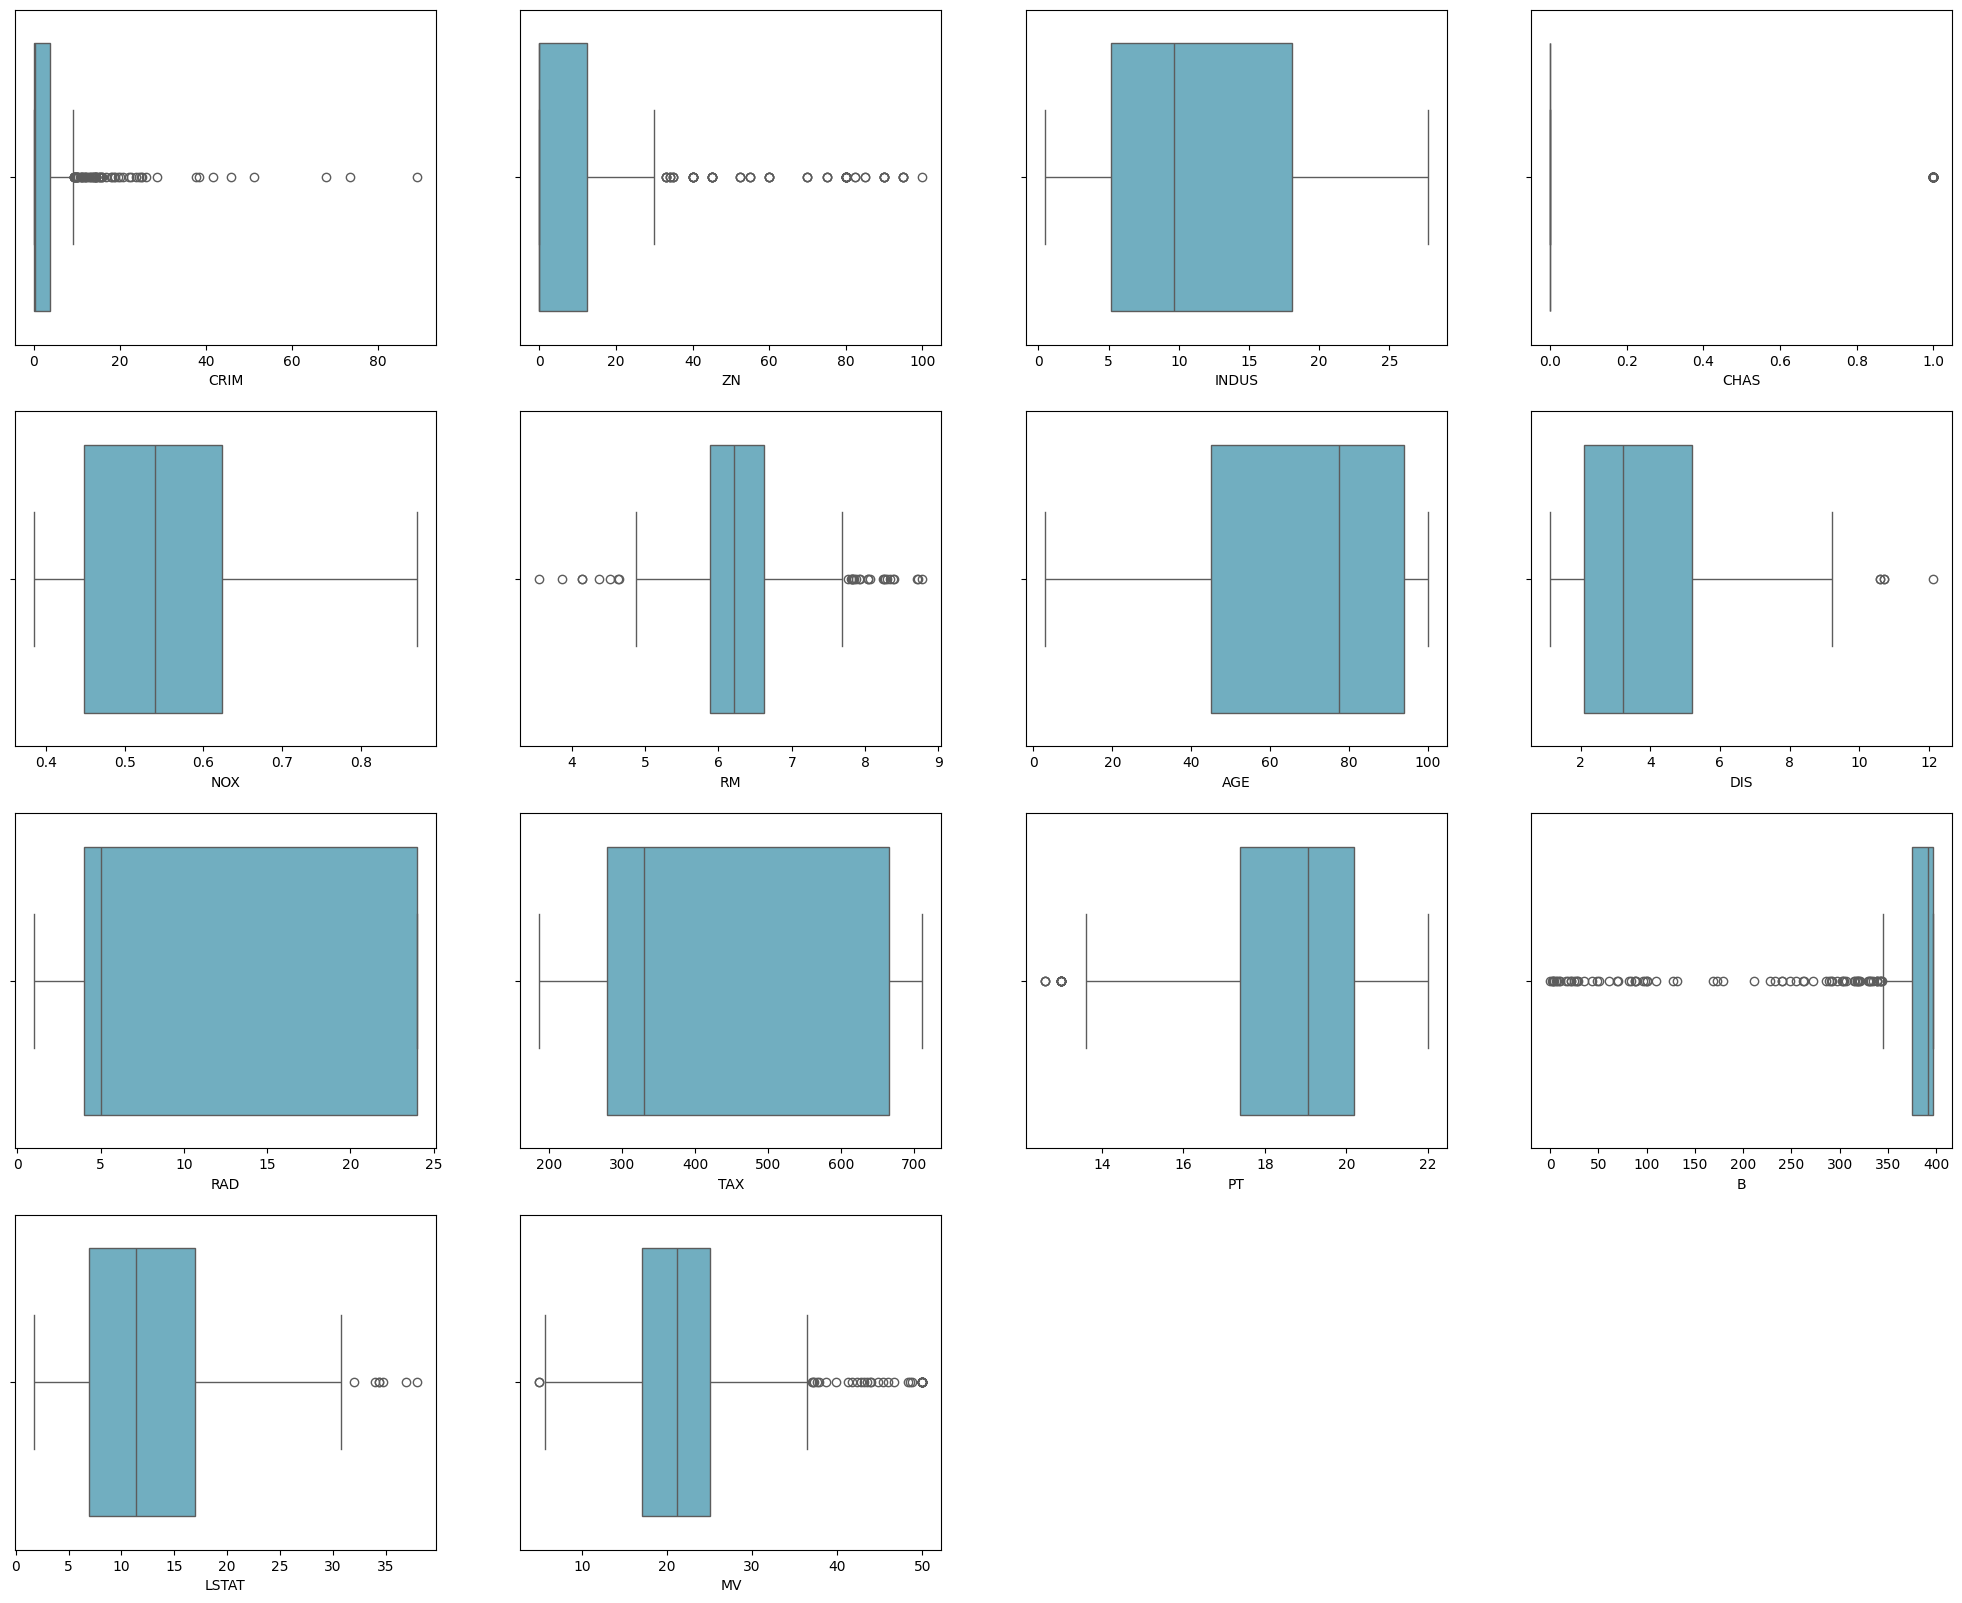

In [9]:
# Structure plots to easily fit the data.
multi_row_plot(sns.boxplot, boston_csv)


Clean outliers from relevant data. I have chosen to winsorize the outliers. I have not altered the "CHAS" column, as that is a dummy value for being beside the river or not, it is certain there are no outliers for that data.

In [10]:
# Create a deep copy as to not alter the original dataset.
boston_win = boston_csv.copy(deep=True)

In [11]:
# Winsorize the data
for col in boston_csv.columns:
    # Skip CHAS column
    if col == 'CHAS':
        continue
    winsorize_outliers(boston_csv, boston_win, col)

In [12]:

# Show the general statistics after winsorization.
boston_win.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PT,B,LSTAT,MV
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,2.225032,6.963439,11.136779,0.069170,0.554695,6.275312,68.574901,3.783947,9.549407,408.237154,18.463834,381.918828,12.612011,21.877075
std,3.313353,12.028788,6.860353,0.253994,0.115878,0.630242,28.148862,2.069765,8.707259,168.537116,2.143925,19.054924,7.016829,7.602976
min,0.006320,0.000000,0.460000,0.000000,0.385000,4.778500,2.900000,1.129600,1.000000,187.000000,13.199998,344.106209,1.730000,5.062500
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377487,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440002,11.360000,21.200001
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.074999,5.188425,24.000000,666.000000,20.200001,396.225006,16.954999,25.000000
max,9.069639,31.250000,27.740000,1.000000,0.871000,7.730500,100.000000,9.820801,24.000000,711.000000,22.000000,396.899994,31.962499,36.962500


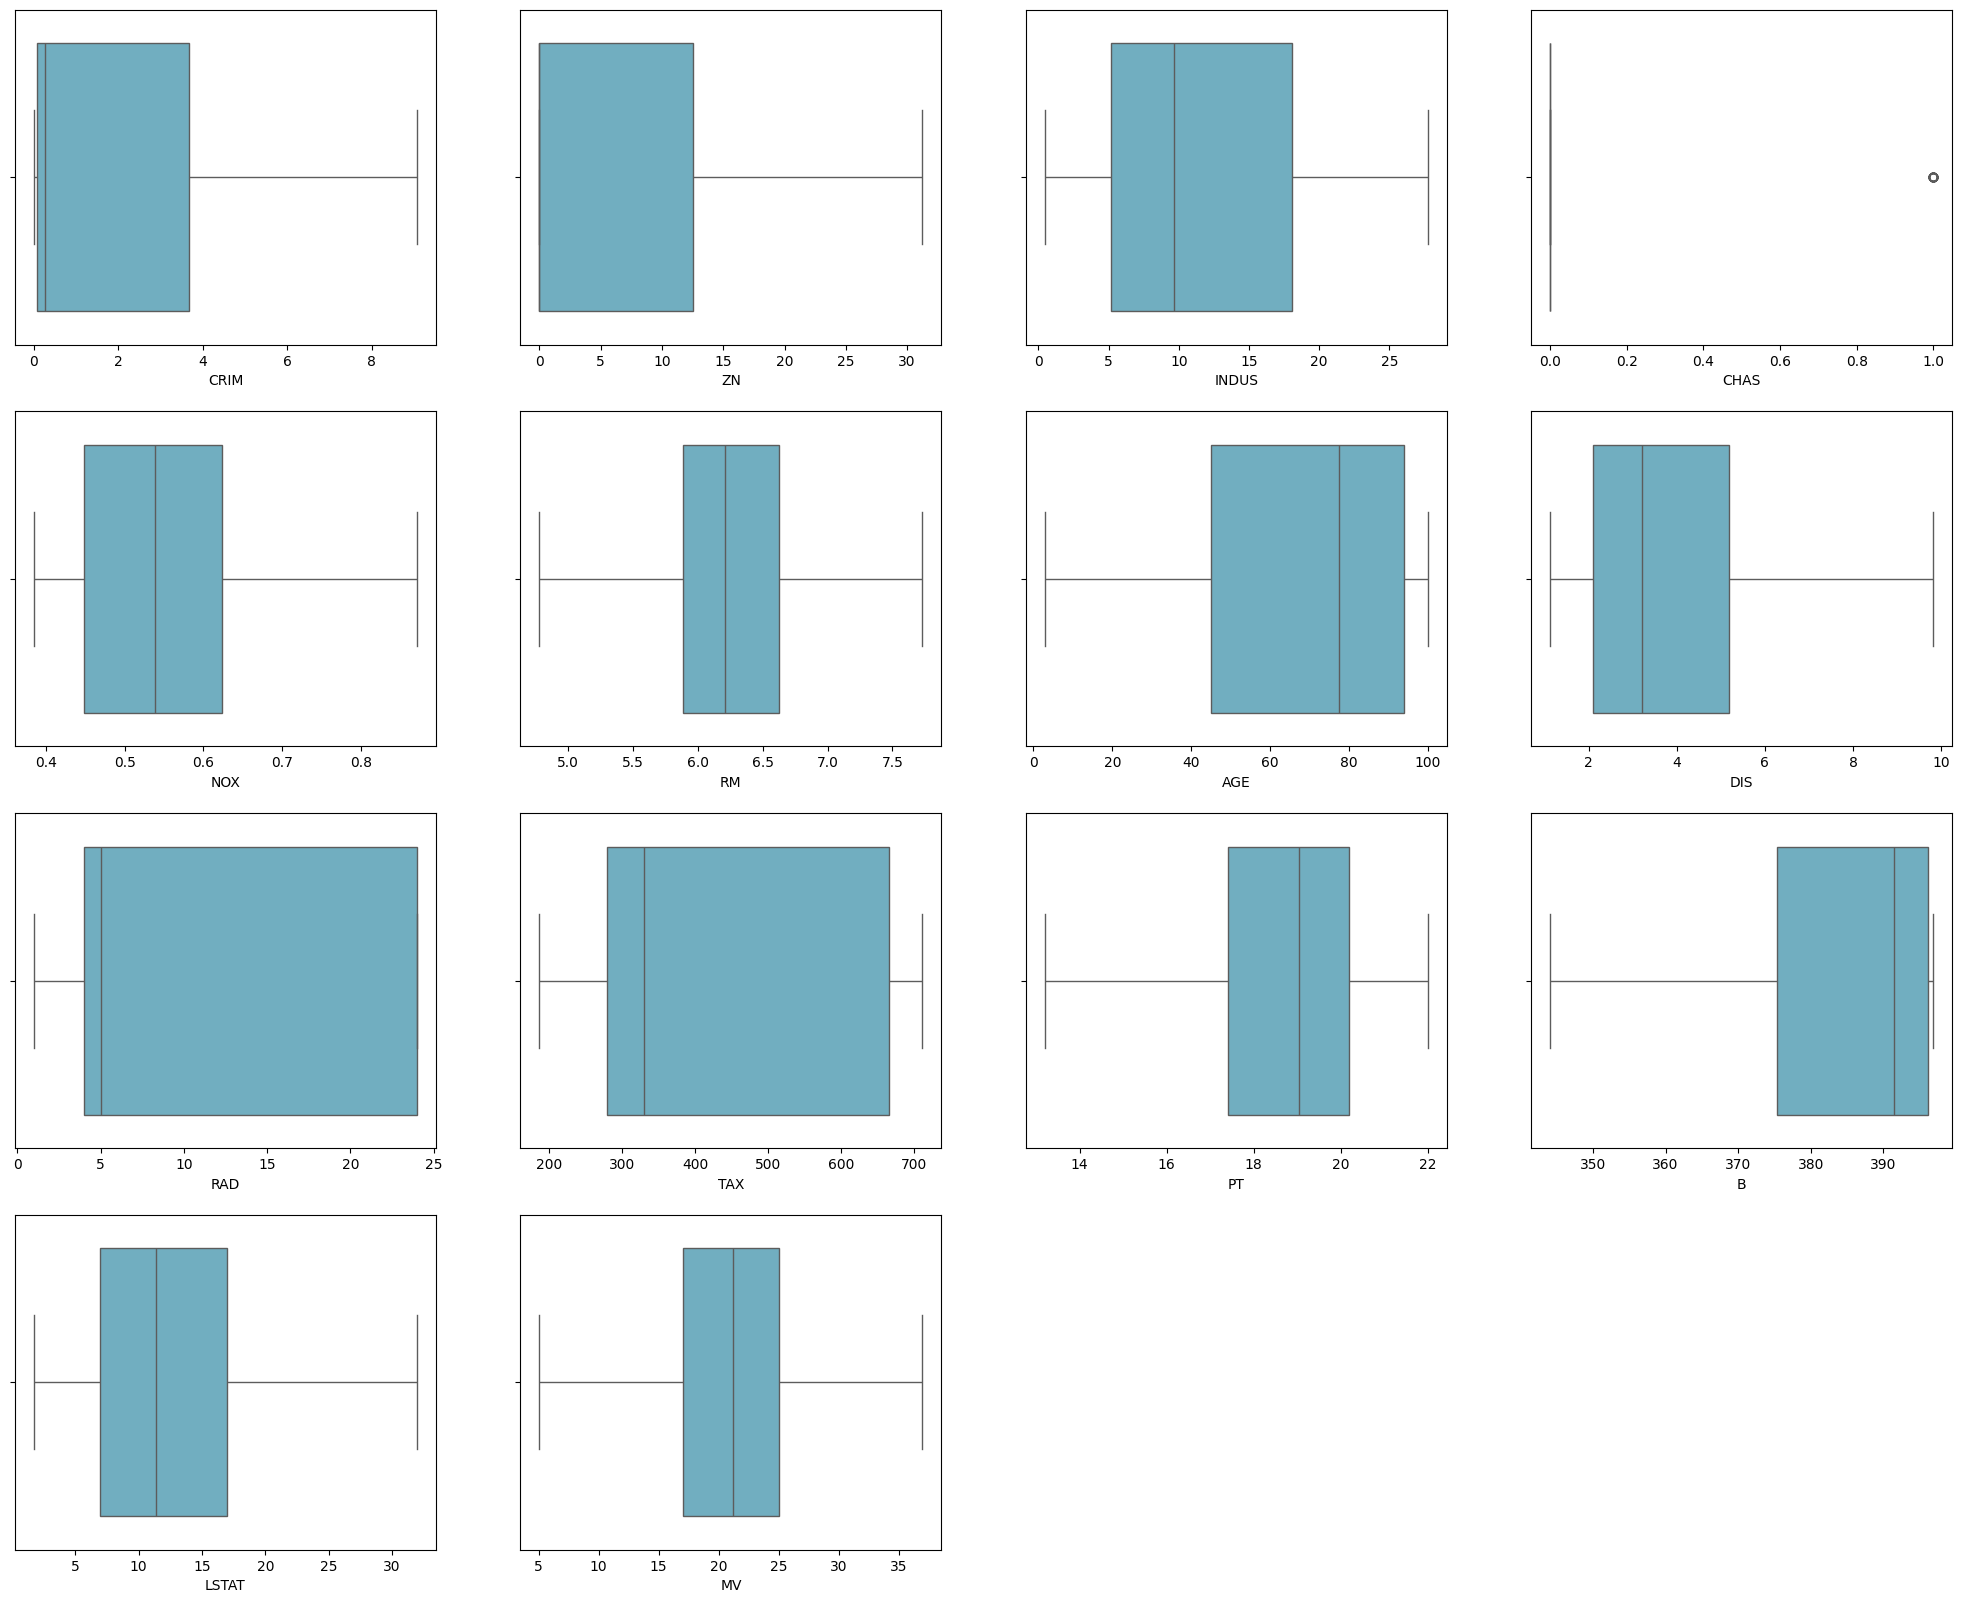

In [13]:
# Display the box plots without outliers.
multi_row_plot(sns.boxplot, boston_win)

Plot histograms to see the distribution of the data. Here you can see the histograms before and after cleaning of the data.

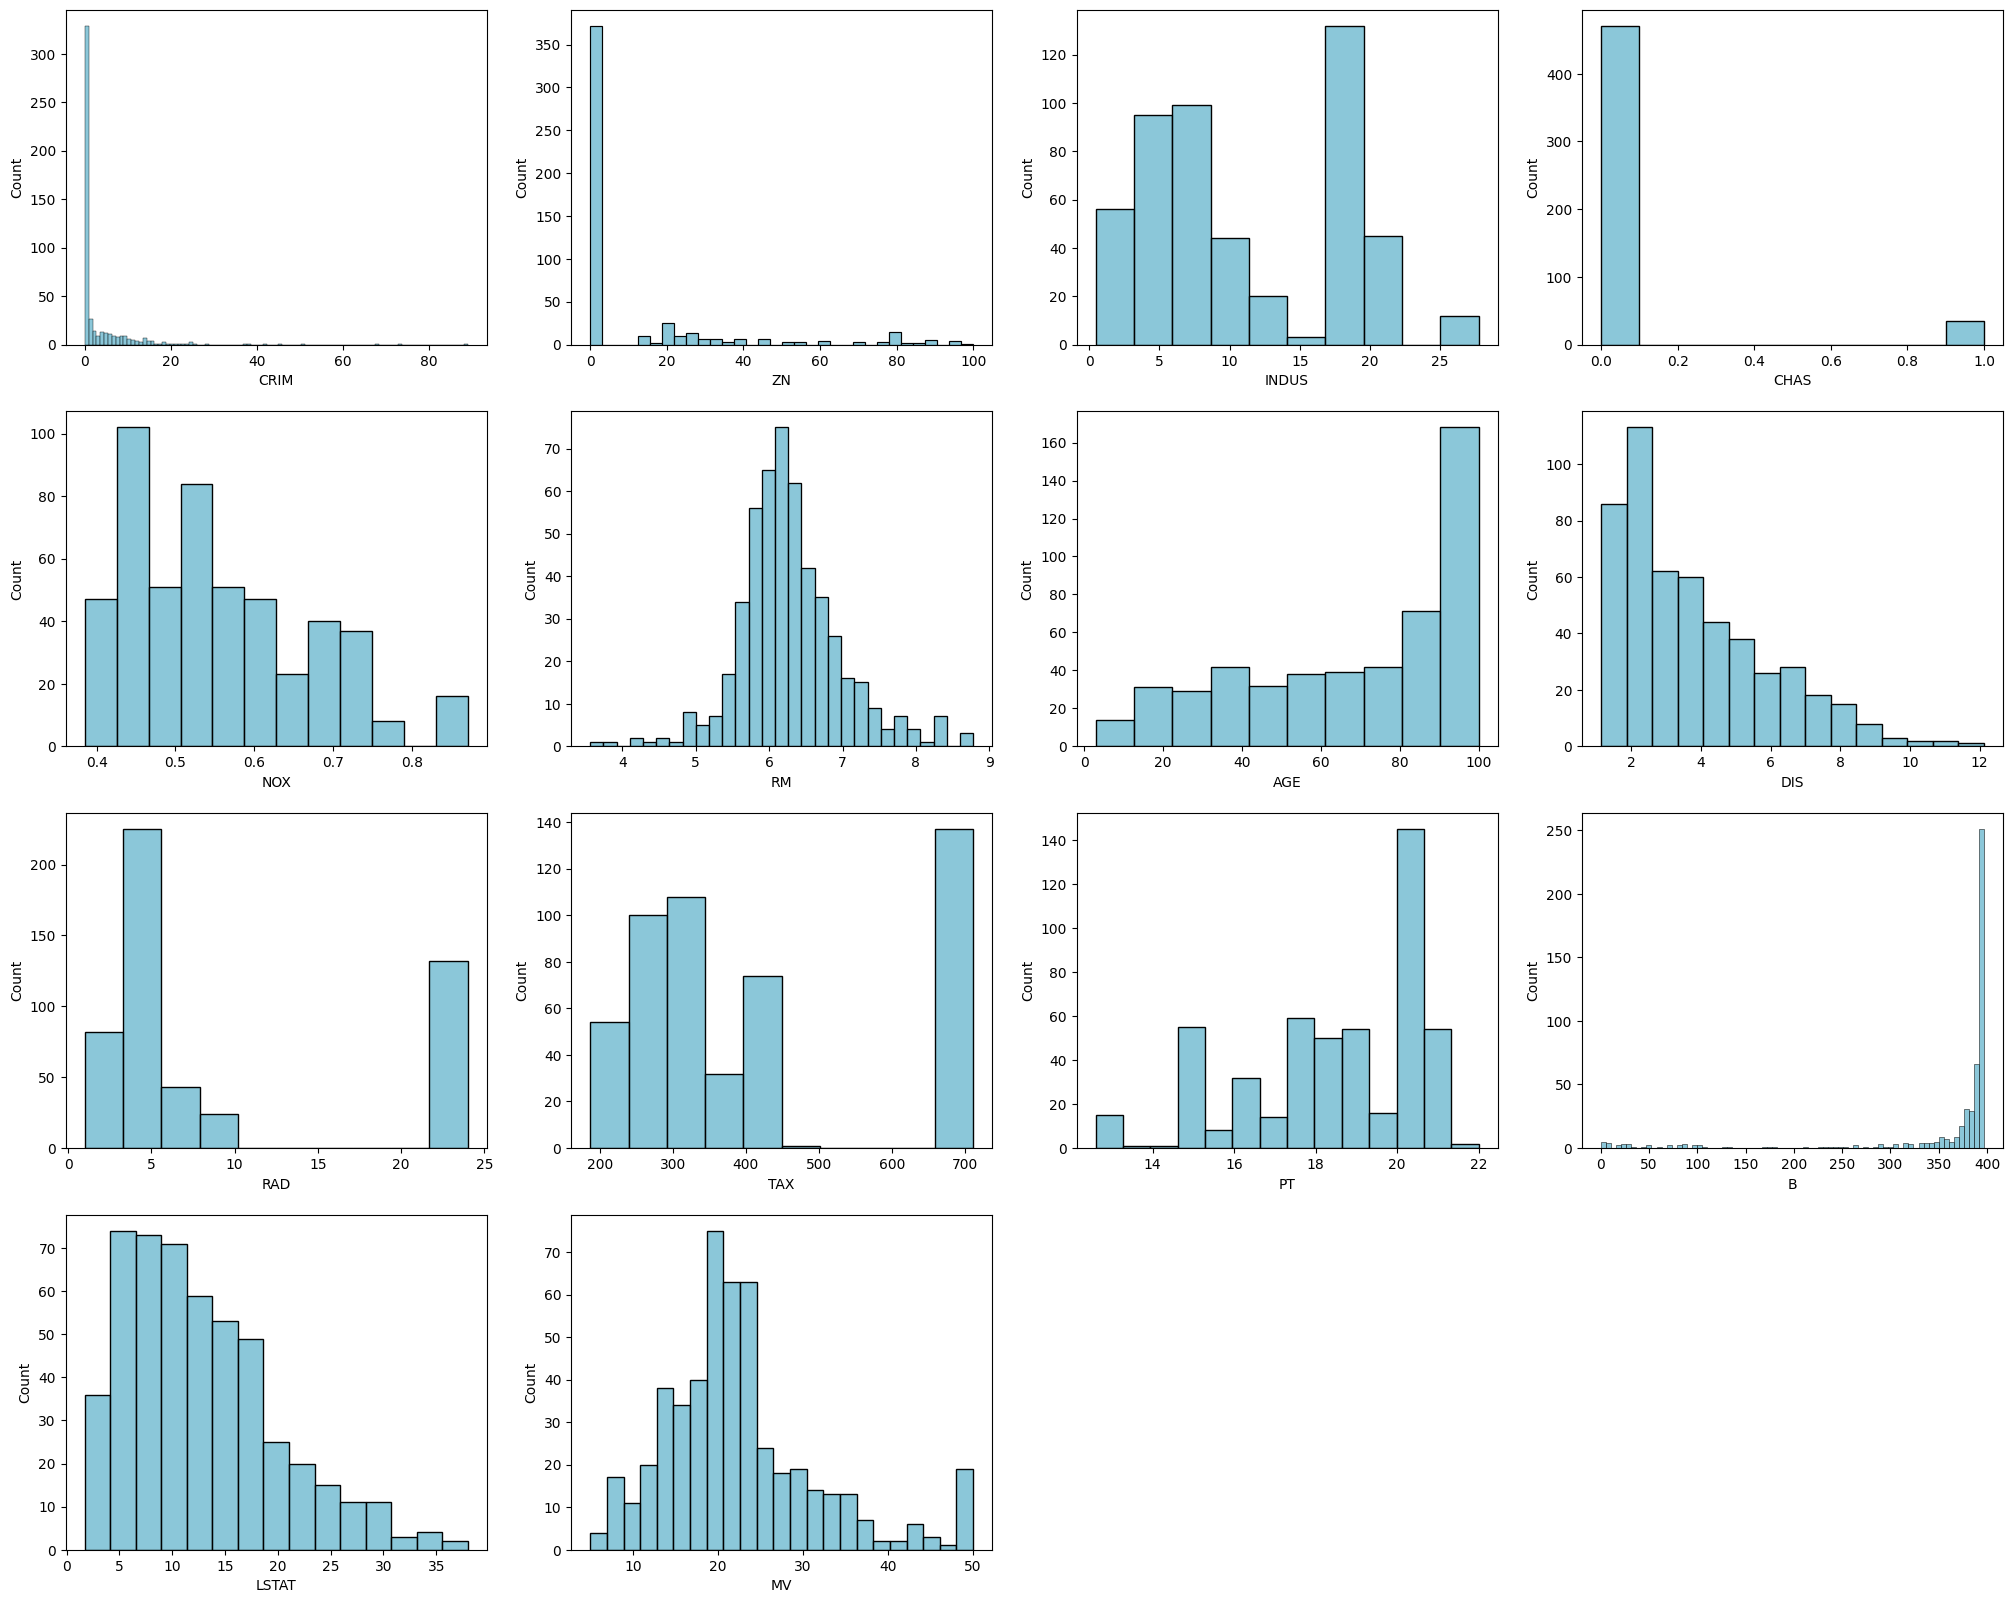

In [14]:
# Before data cleaning
multi_row_plot(sns.histplot, boston_csv)

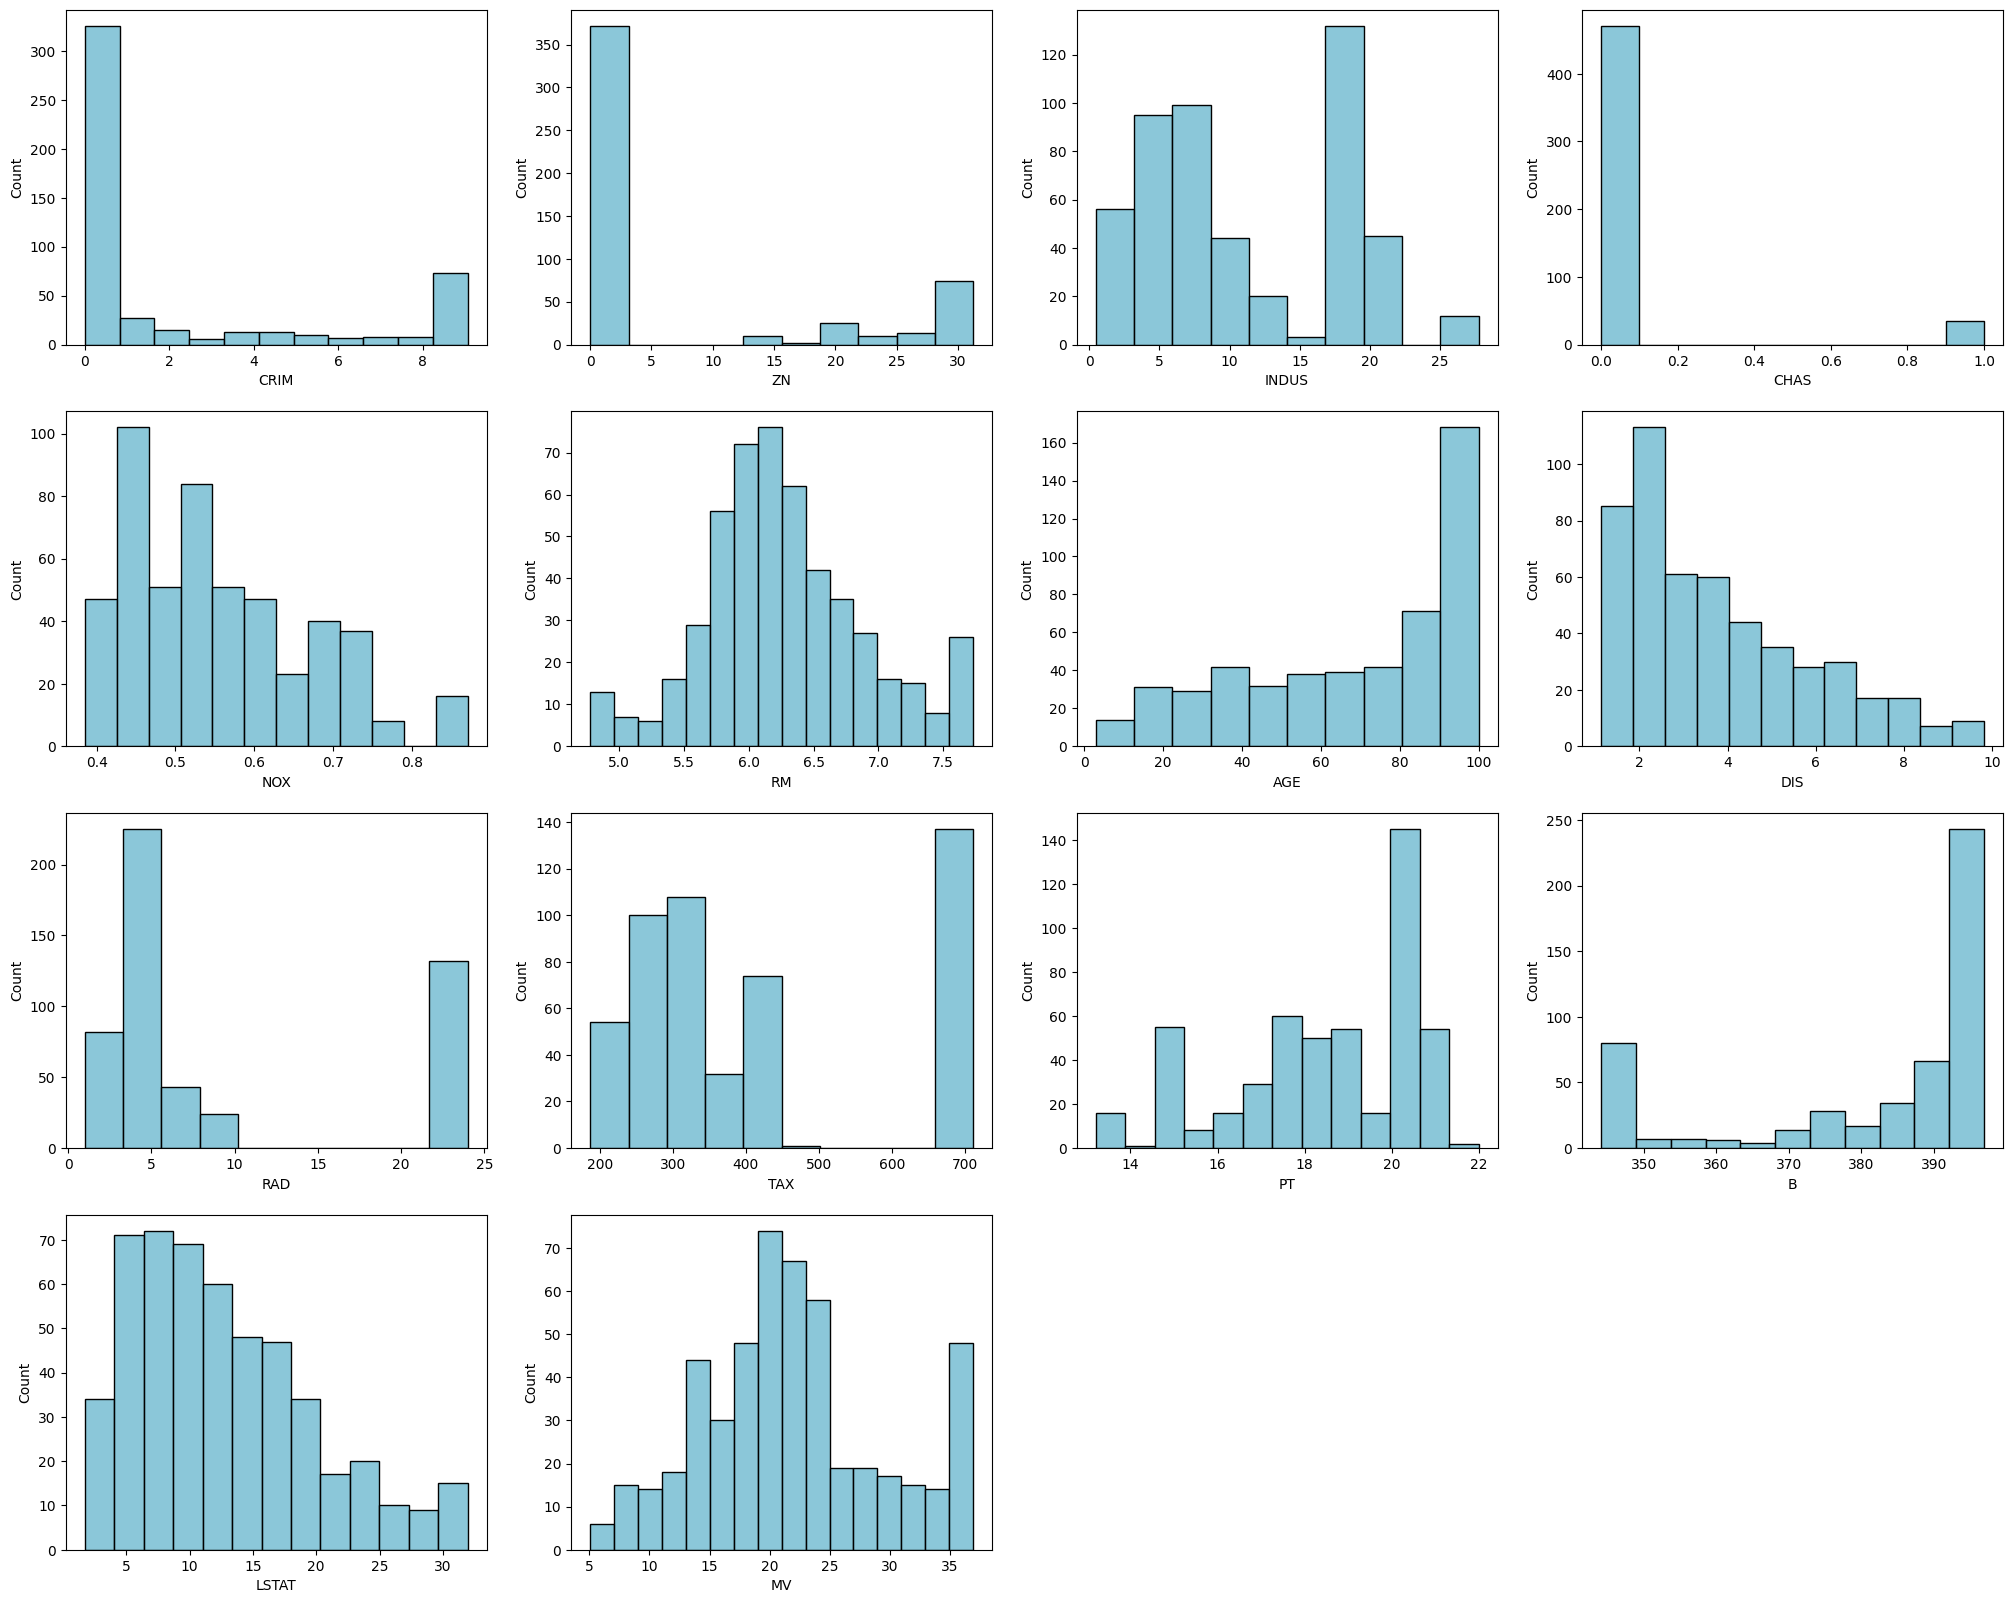

In [15]:
# Structure plots to easily fit the data.
multi_row_plot(sns.histplot, boston_win)

Add violin plots to show median, interquartile range, concentration of values and distribution.


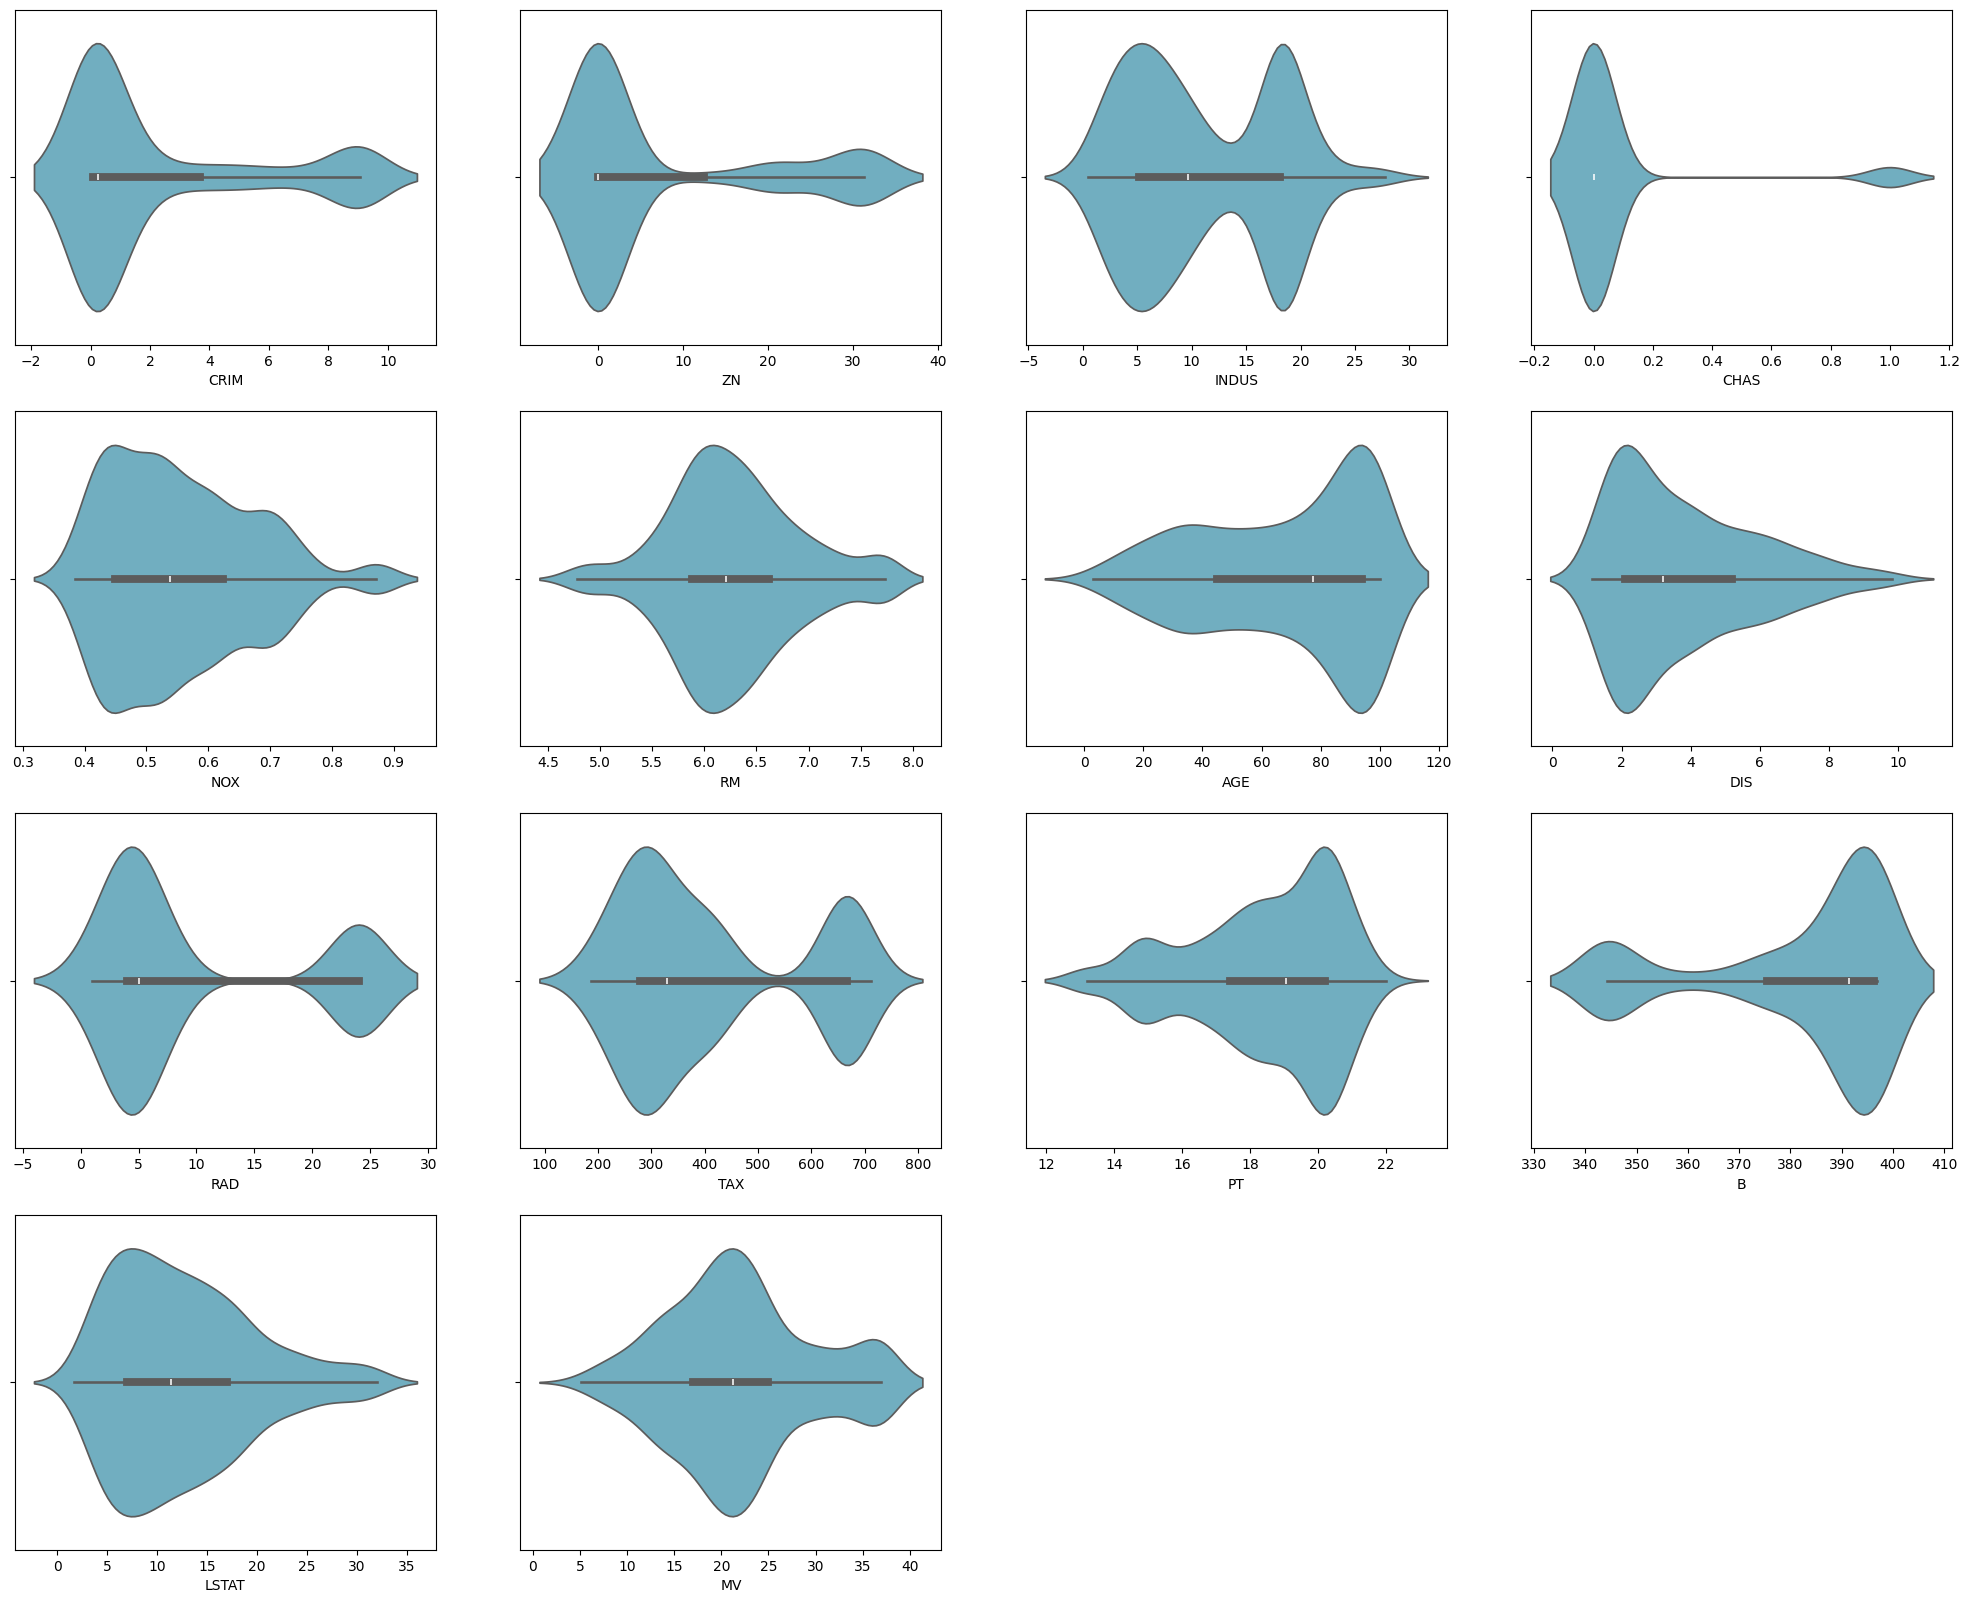

In [16]:
multi_row_plot(sns.violinplot, boston_win)

A heatmap will give an overview of correlation coefficients. I have used absolute values so it is easier to read, however positive or negative slope will not be shown.


<Axes: >

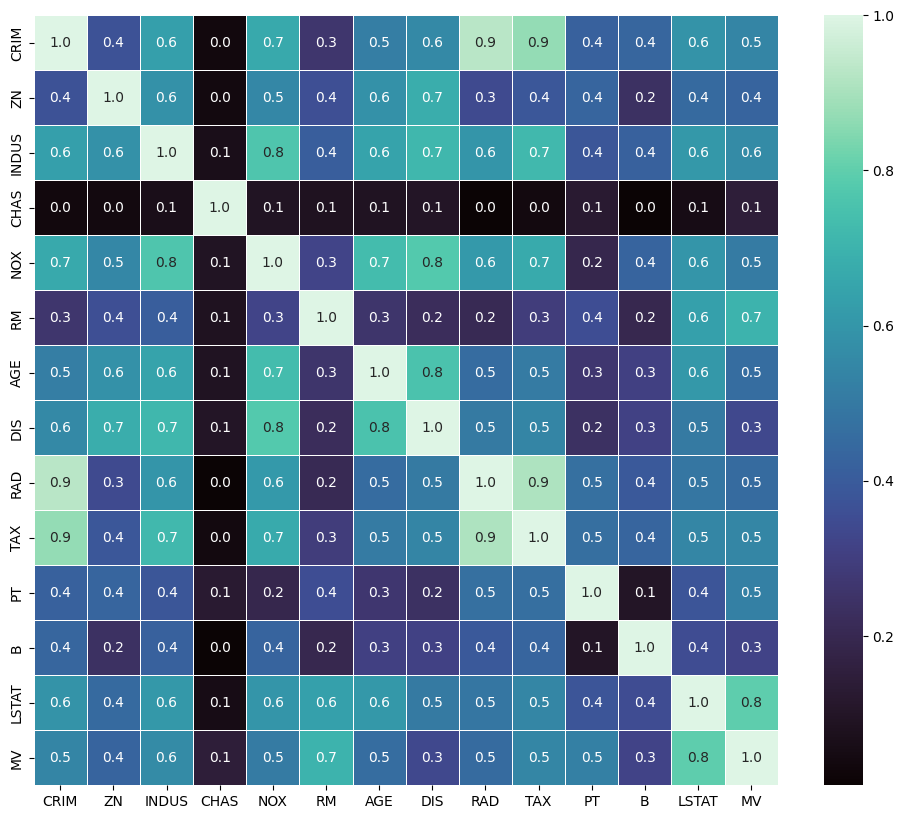

In [17]:
plt.figure(figsize=(12, 10))

# Use absolute values to focus on correlation rather than slope direction.
corr_matrix = boston_win.corr().abs()
sns.heatmap(corr_matrix, annot=True, fmt='.1f', linewidth=0.5, cmap="mako")

Add pairplot for graph comparison with heatmap. Side by side, these are easier for a quick comparison.


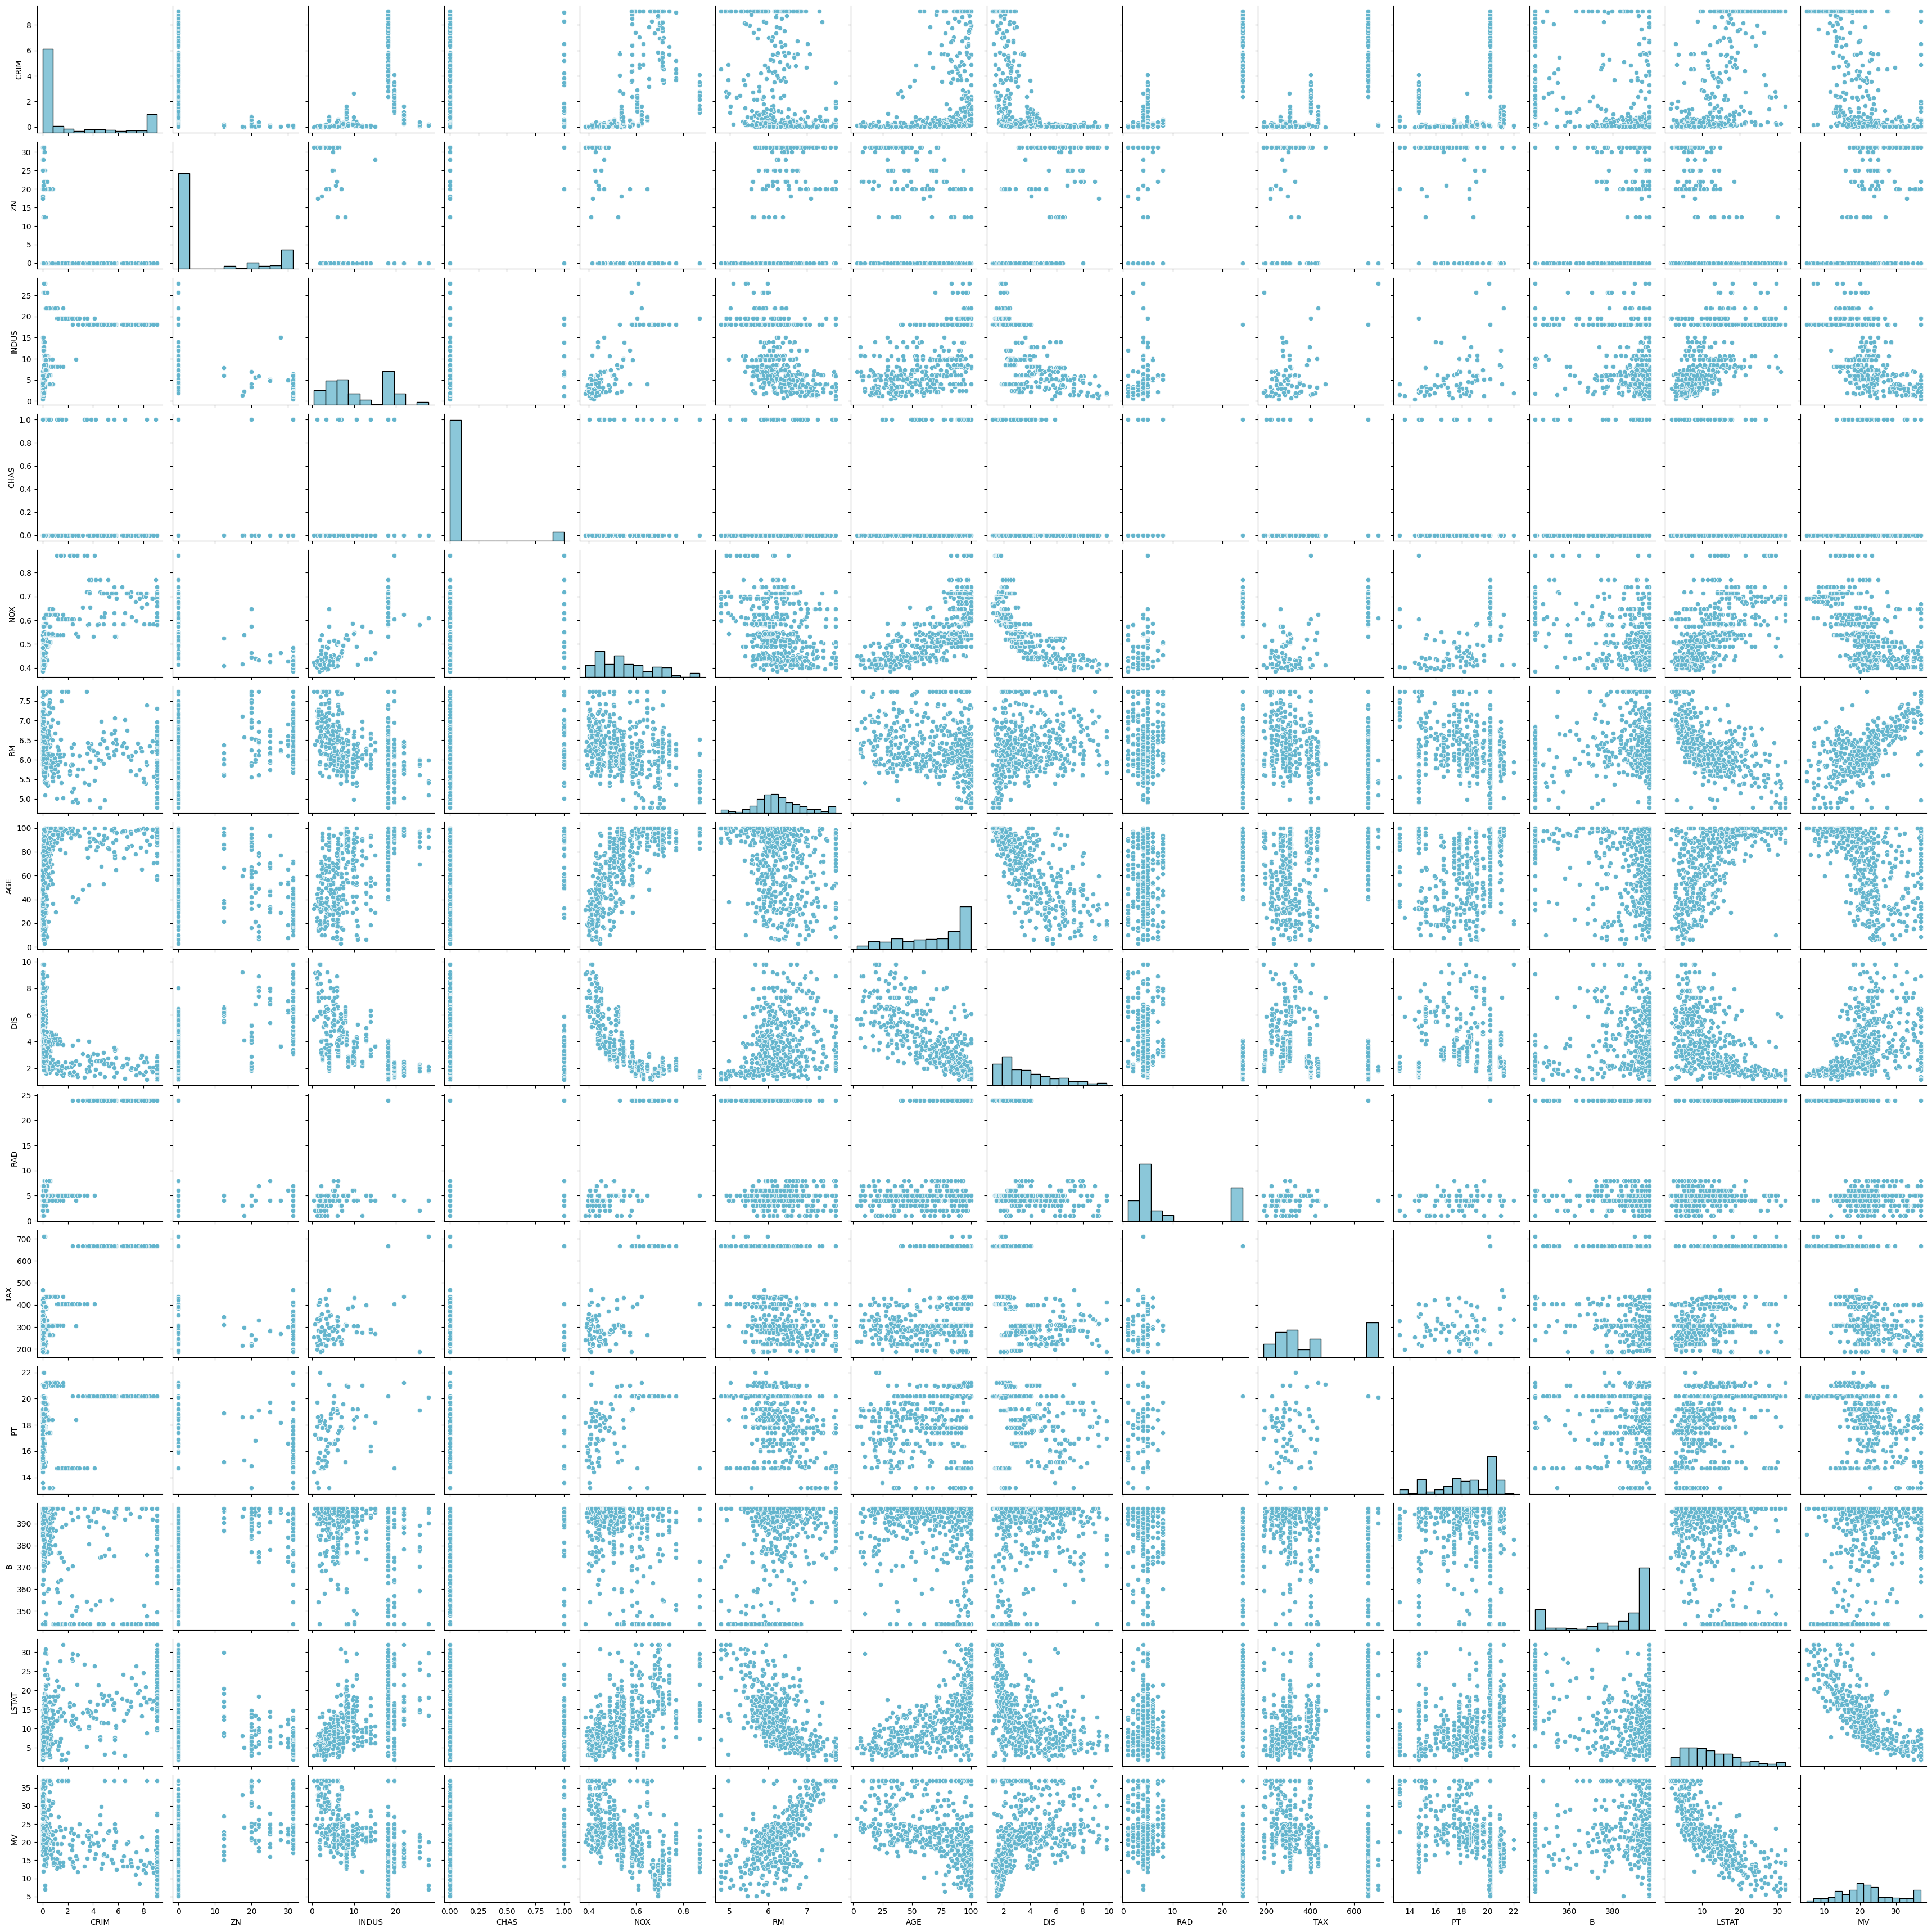

In [18]:
sns.pairplot(boston_win)

Finally, generate scatter plots for comparing response (crime) tp the other predictors.


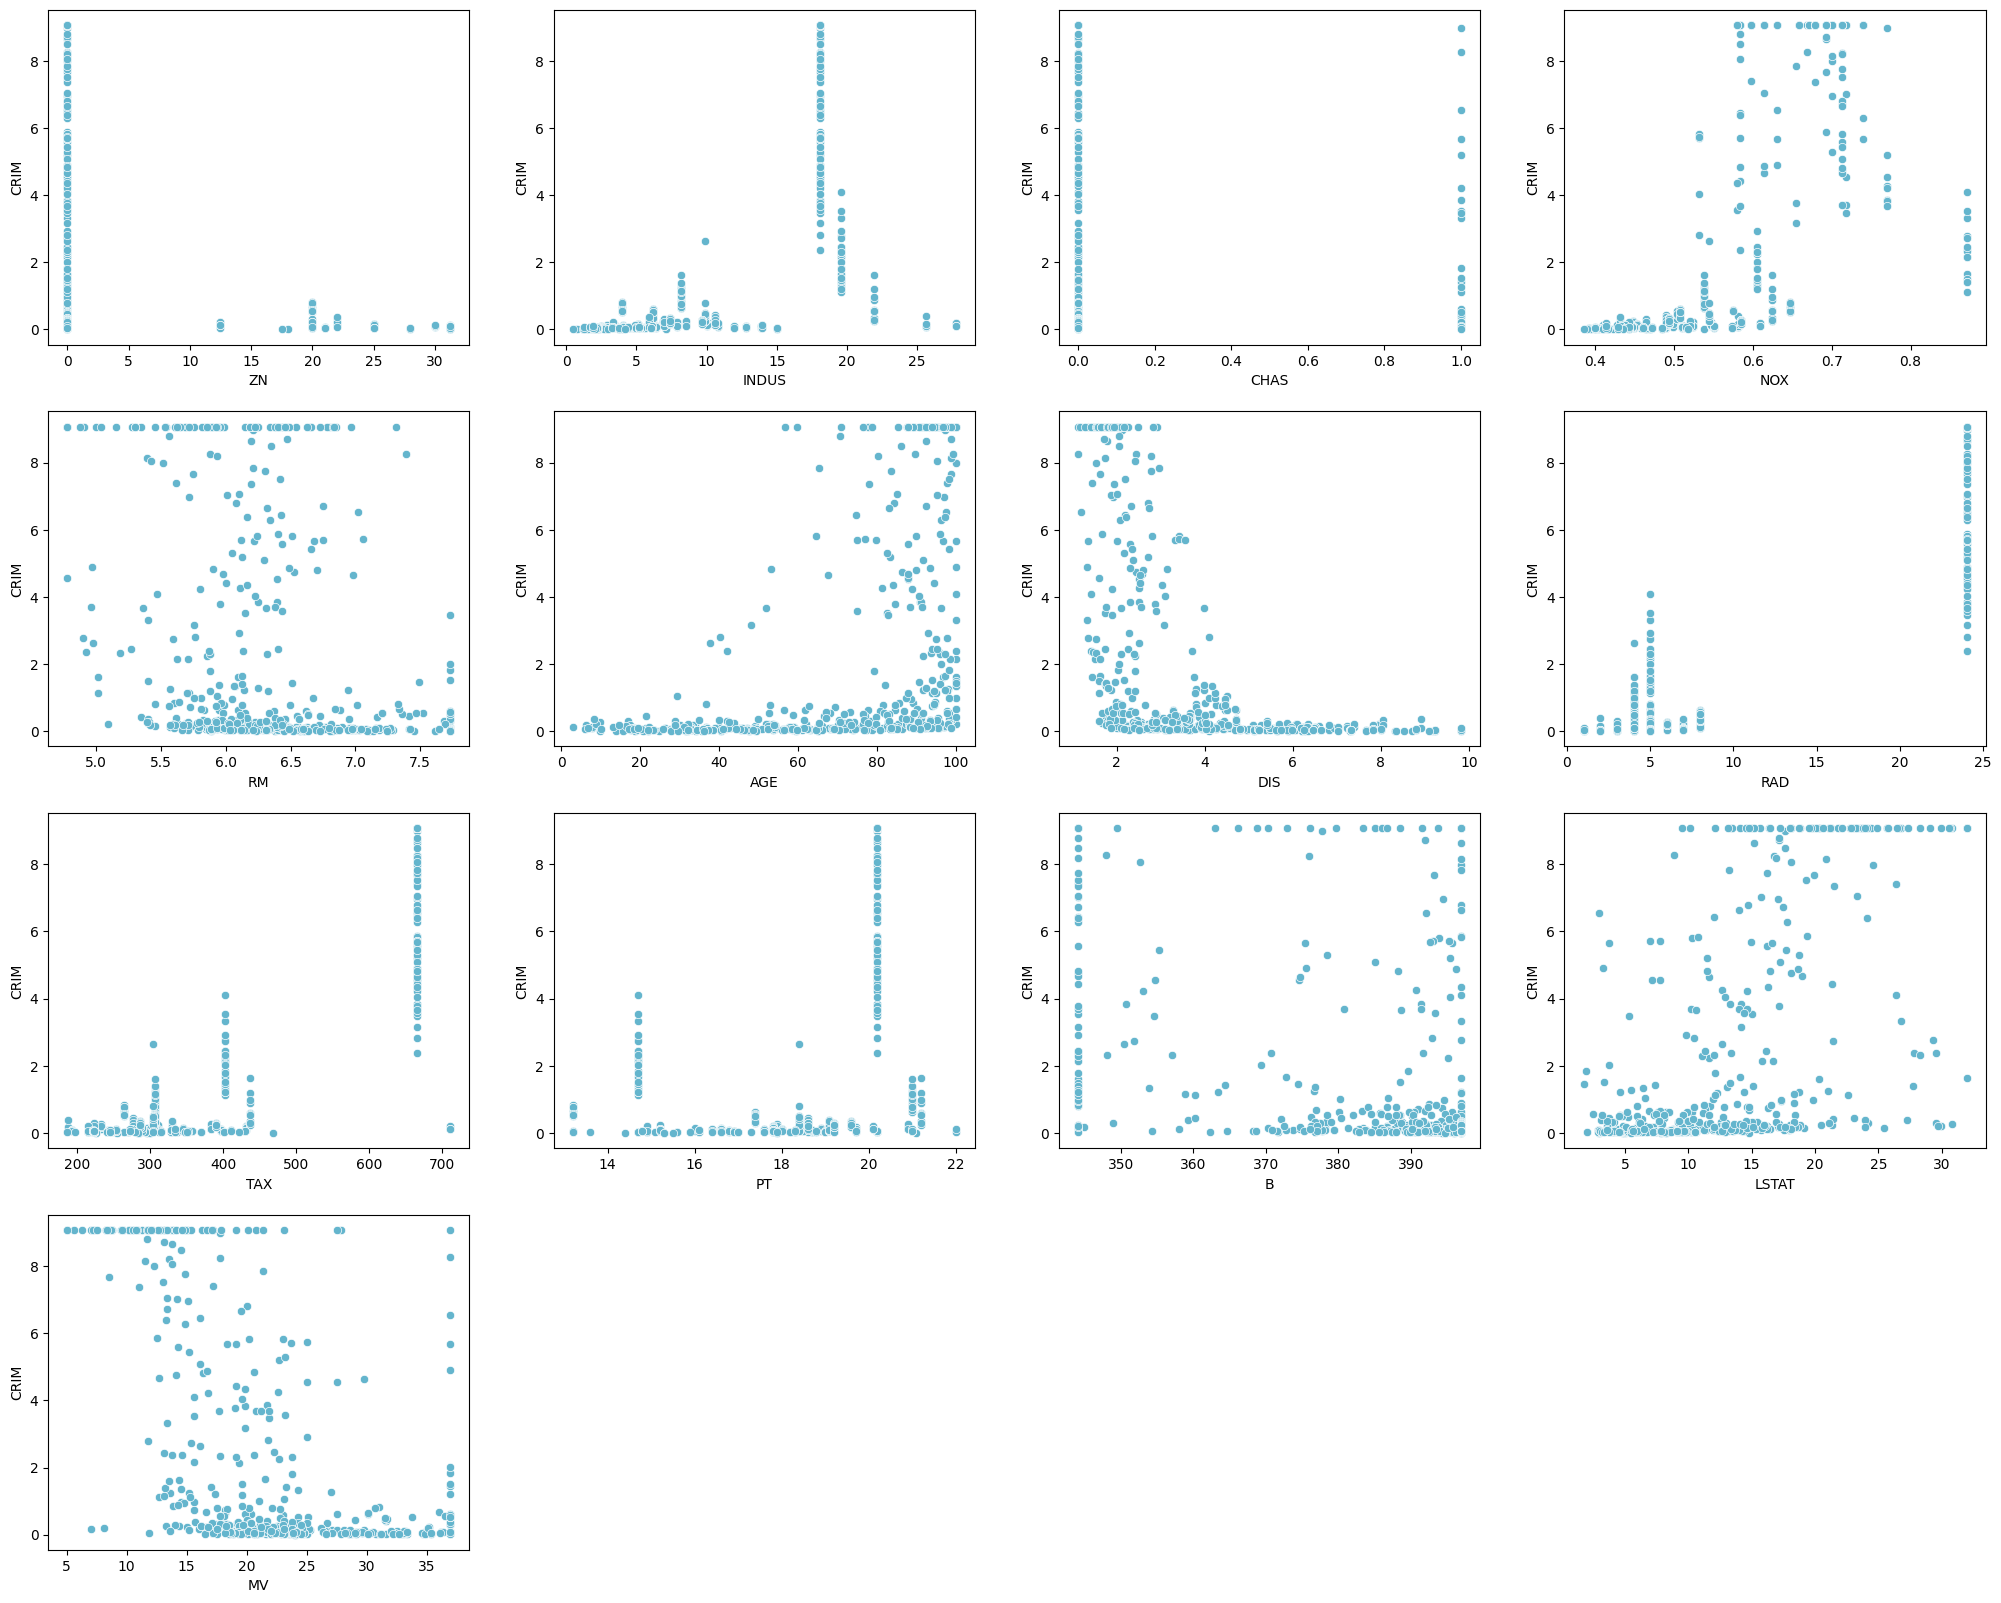

In [19]:
multi_row_plot(sns.scatterplot, boston_win, y_col=True)

## Linear regression  

### b) For each predictor, fit a simple linear regression model to predict the response. Complete regression analysis. Describe your results. In which of the models is there a statistically significant association between the predictor and the response? Create plots to back up your assertions.

First I will run a linear regression on each of the predictors to examine important values, such as rsquared, F-statistics, p-values, coefficients, etc. I will also examine residuals.

In [ ]:
# Initalise a results for an easily copiable table
ols_results = []

# Run the response against each predictor.
for col in boston_win.columns[1:]:
    model = ols(f'CRIM ~ {col}', boston_win).fit()
    print(model.summary(), '\n')
    # Display stats for residuals.
    print(
        f'R**2 is {model.rsquared}\n'
        f'MSE Residual is {model.mse_resid}\n'
        f'Residual Standard error is {model.mse_resid**0.5}\n\n\n',
    )

    # Extract confidence intervals
    conf_int = model.conf_int().loc[col]

    # Append results to create data frame later.
    result = {
        'Predictor': col,
        'R-squared': model.rsquared,
        'MSE Residual': model.mse_resid,
        'Residual Std Err': model.mse_resid**0.5,
        'Coefficient': model.params[col],
        'Std Err': model.bse[col],
        'T-value': model.tvalues[col],
        'P-value': model.pvalues[col],
        'CI Lower': conf_int[0],
        'CI Upper': conf_int[1],
    }
    ols_results.append(result)

for result in ols_results:
    for key, value in result.items():
        if isinstance(value, (int, float)):
            result[key] = round(value, 3)

                            OLS Regression Results                            
Dep. Variable:                   CRIM   R-squared:                       0.137
Model:                            OLS   Adj. R-squared:                  0.135
Method:                 Least Squares   F-statistic:                     80.05
Date:                Thu, 05 Jun 2025   Prob (F-statistic):           6.99e-18
Time:                        17:26:32   Log-Likelihood:                -1286.4
No. Observations:                 506   AIC:                             2577.
Df Residuals:                     504   BIC:                             2585.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.9351      0.158     18.542      0.0

In [ ]:
# Create a DataFrame from the results
results_df = pd.DataFrame(ols_results)

results_df

,Predictor,R-squared,MSE Residual,Residual Std Err,Coefficient,Std Err,T-value,P-value,CI Lower,CI Upper
0,ZN,0.137,9.492,3.081,-0.102,0.011,-8.947,0.00,-0.124,-0.080
1,INDUS,0.396,6.644,2.578,0.304,0.017,18.179,0.00,0.271,0.337
2,CHAS,0.001,10.990,3.315,-0.401,0.581,-0.691,0.49,-1.542,0.740
3,NOX,0.440,6.159,2.482,18.969,0.953,19.904,0.00,17.097,20.842
4,RM,0.068,10.256,3.203,-1.367,0.226,-6.046,0.00,-1.811,-0.923
5,AGE,0.269,8.038,2.835,0.061,0.004,13.629,0.00,0.052,0.070
6,DIS,0.308,7.611,2.759,-0.889,0.059,-14.980,0.00,-1.005,-0.772
7,RAD,0.859,1.548,1.244,0.353,0.006,55.477,0.00,0.340,0.365
8,TAX,0.758,2.661,1.631,0.017,0.000,39.742,0.00,0.016,0.018
9,PT,0.173,9.094,3.016,0.643,0.063,10.278,0.00,0.520,0.766


I use seaborn regplot to do an automatic linear regression on each predictor for better visualisation.

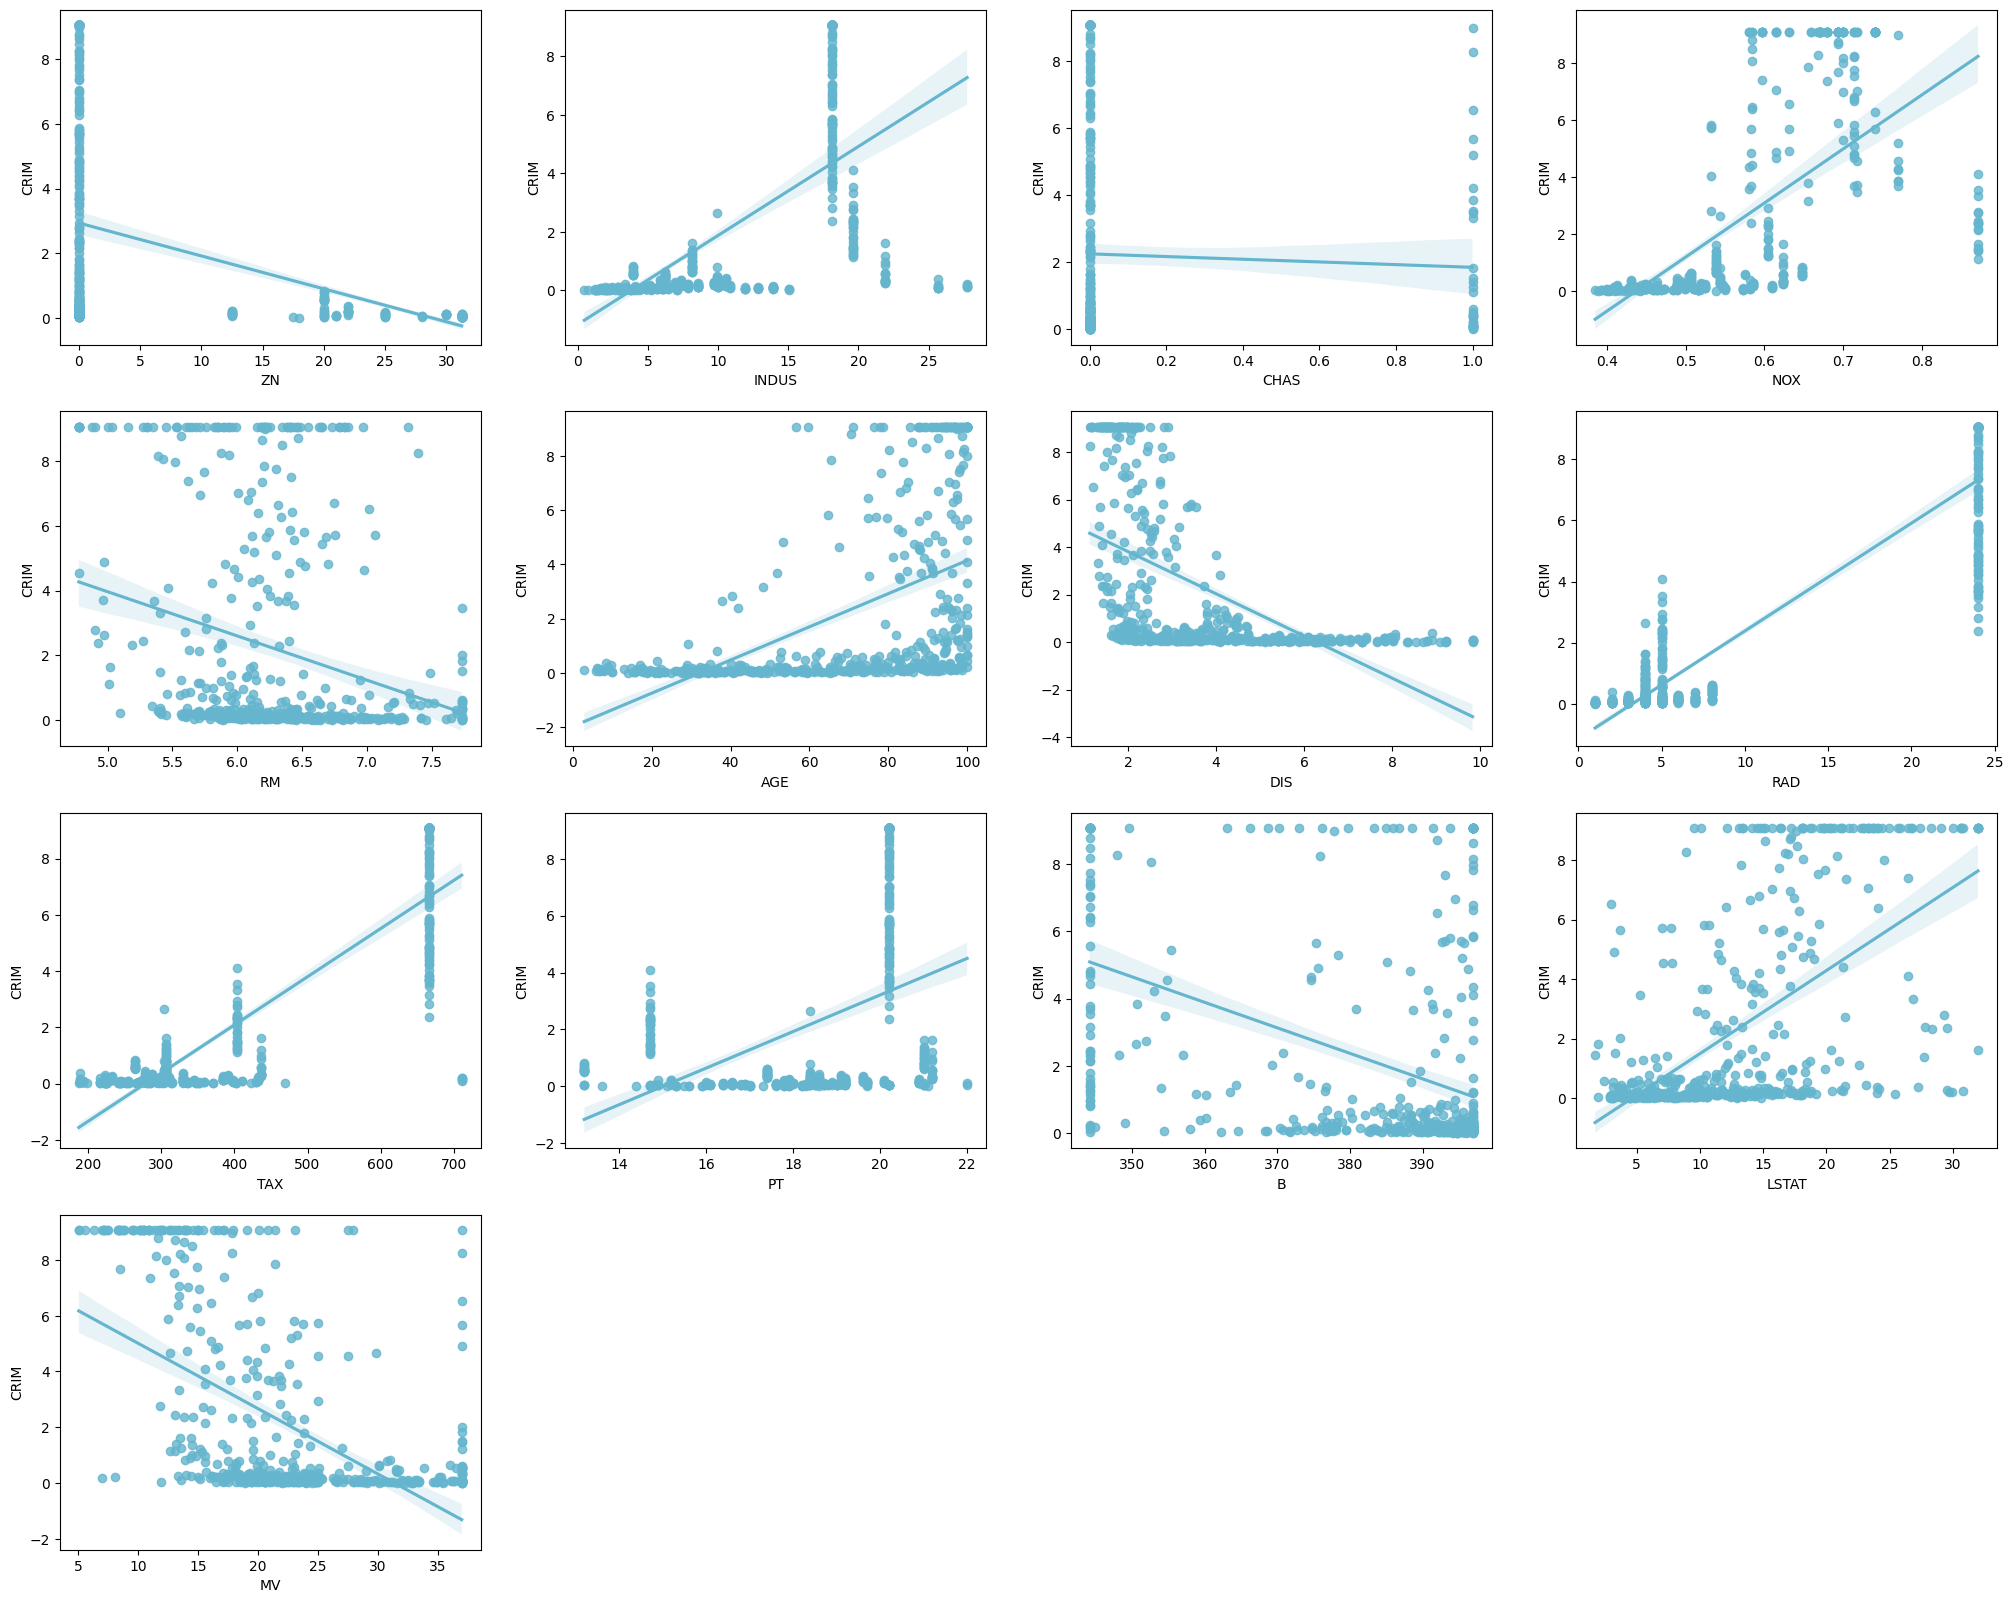

In [23]:
multi_row_plot(sns.regplot, boston_win, y_col=True)